In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import sem
import matplotlib.cm as cm
from configs import engram_dir
import sys

In [11]:
sys.path.append(os.path.abspath('../scripts/model_parameters'))

In [12]:
from gridworld import parameter_map

# Helper functions

In [9]:
def get_colors(models):
    cmap = cm.get_cmap('Oranges')
    c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
    colors = []
    for model in models:
        if model.startswith('mf'):
            colors.append('C0')
        elif model.startswith('entro'):
            colors.append('C2')
        elif model.startswith('iqn'):
            colors.append('C4')
        elif model.startswith('g0.8'):
            colors.append(cmap(c_steps[3]))
        elif model.startswith('g0.5'):
            colors.append(cmap(c_steps[2]))
        elif model.startswith('g0.25'):
            colors.append(cmap(c_steps[1]))
        elif model.startswith('g0'):
            colors.append(cmap(c_steps[0]))
        else:
            colors.append('black')
    return colors

In [4]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

def get_df(base, zs, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [], 'file': []}
    for z in zs:
        task_dir = f'{base}_{net_yaml}_dim{z}_shuffobs'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
                data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

In [5]:
def plot(
    df, plot_key, plot_ep, figsize=(6.4*0.75, 4.8*0.75),
    fnames=None, figname=None, labels=None,
    smooth_plot=True, smooth_plot_n=2, colors=None,
    legend_title=None, ylim=None, plot_title=None, show_legend=True,
    ylabel='Avg Episode Score', xlim=None):
    
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_width = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            means = []
            sems = []
            val_len = 0
            for ep in episode:
                vals = df_subset[df_subset['episode']==ep]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
                if ep == plot_ep:
                    val_len = len(vals)
            means = np.array(means)
            sems = np.array(sems)
            if z == 5:
                print(fname)
                print(f'Mean: {means[plot_ep]}, SEM: {sems[plot_ep]} for {val_len} vals')
            line.append(means[plot_ep])
            shading_width.append(sems[plot_ep])
        line = np.array(line)
        shading_width = np.array(shading_width)
        if smooth_plot:
            line = smooth(zs, line, smooth_plot_n)
            shading_width = smooth(zs, shading_width, smooth_plot_n)
        shading_lower = line - shading_width
        shading_upper = line + shading_width
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    if show_legend: plt.legend(title=legend_title)
    if ylabel != None:
        plt.ylabel(ylabel)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.xlabel('Latent Size')
    if figname != None:
        plt.savefig(figname + '.png', dpi=300, transparent=True)
    plt.show()

# Task A

In [6]:
zs = np.arange(2, 22)
base = 'gridworld_discount0.9_eps1.0'

In [7]:
recalculate = True
if recalculate:
    task_df = get_df(base, zs, 'dm_large_q')
    with open('pickles/2c_taskA.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/2c_taskA.p', 'rb') as f:
        task_df = pickle.load(f)

mf0
Mean: 0.8133333333333335, SEM: 0.06798692684790379 for 25 vals
entro-1
Mean: 0.936, SEM: 0.03321757678409741 for 25 vals
g0_-2_entro-1
Mean: 0.9946666666666667, SEM: 0.005333333333333333 for 25 vals
g0.25_-2_entro-1
Mean: 1.0, SEM: 0.0 for 25 vals
g0.5_-3_entro-2
Mean: 0.9573333333333334, SEM: 0.024 for 25 vals
g0.8_-4_entro0
Mean: 0.9253333333333335, SEM: 0.029393876913398138 for 25 vals


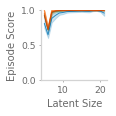

In [16]:
plot(
    task_df, 'valid_score', 600, figsize=(1.5, 1.5),
    fnames=models,
    show_legend=False,
    smooth_plot=True, smooth_plot_n=4,
    colors=get_colors(models),
    ylim=(0,1), ylabel='Episode Score', #xlim=[7,20]
    )

# Task B

In [10]:
zs = np.arange(2, 22)
base = 'frozentransfer_gridworld_discount0.9_eps1.0'

In [17]:
recalculate = True
if recalculate:
    task_df = get_df(base, zs, 'dm_large_q')
    with open('pickles/2c_frozentransfer.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/2c_frozentransfer.p', 'rb') as f:
        task_df = pickle.load(f)

In [18]:
models = parameter_map['selected_models_large_q']()[0]
#models = parameter_map['selected_models_grid_shuffle']()[0]

In [22]:
_models = [
 'g0_-2_entro-1',
 'g0.25_-2_entro-1',
 'g0.5_-3_entro-2',
 'g0.8_-4_entro0']

g0_-2_entro-1
Mean: 0.44000000000000017, SEM: 0.04760952285695233 for 25 vals
g0.25_-2_entro-1
Mean: 0.44000000000000017, SEM: 0.050184843513938725 for 25 vals
g0.5_-3_entro-2
Mean: 0.4346666666666667, SEM: 0.050934962161273564 for 25 vals
g0.8_-4_entro0
Mean: 0.3653333333333333, SEM: 0.041832115962809314 for 25 vals


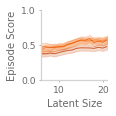

In [23]:
plot(
    task_df, 'valid_score', 100, figsize=(1.5, 1.5),
    fnames=_models,
    show_legend=False,
    smooth_plot=True, smooth_plot_n=3,
    colors=get_colors(_models),
    ylim=(0,1), ylabel='Episode Score', xlim=[6,21],
    #figname='2c'
    )

g0_-2_entro-1
Mean: 0.816, SEM: 0.053924501405686186 for 25 vals
g0.25_-2_entro-1
Mean: 0.9146666666666668, SEM: 0.02388863048955856 for 25 vals
g0.5_-3_entro-2
Mean: 0.7226666666666668, SEM: 0.06355866348267326 for 25 vals
g0.8_-4_entro0
Mean: 0.6559999999999999, SEM: 0.057822205141341745 for 25 vals


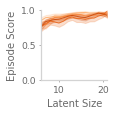

In [24]:
plot(
    task_df, 'valid_score', 200, figsize=(1.5, 1.5),
    fnames=_models,
    show_legend=False,
    smooth_plot=True, smooth_plot_n=3,
    colors=get_colors(_models),
    ylim=(0,1), ylabel='Episode Score', xlim=[6,21],
    #figname='2c'
    )

# Test

In [4]:
zs = np.arange(2, 22)

In [5]:
recalculate = True
if recalculate:
    task_df = get_df('frozentransfer_new_gridworld8x8_shuffobs', zs, 'dm_large_q')
#     with open('pickles/2c_frozentransfer.p', 'wb') as f:
#         pickle.dump(task_df, f)
else:
    with open('pickles/2c_frozentransfer.p', 'rb') as f:
        task_df = pickle.load(f)

In [6]:
np.unique(task_df['model'])

array(['entro2', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0',
       'g0_-2_entro-1', 'mf0'], dtype=object)

mf
Mean: nan, SEM: nan for 0 vals
entro
Mean: nan, SEM: nan for 0 vals
g0_-2_entro-1
Mean: 0.5766666666666668, SEM: 0.06300580767489838 for 30 vals
g0.25_-2_entro0
Mean: 0.7433333333333333, SEM: 0.05543627040691276 for 30 vals
g0.5_-2_entro0
Mean: 0.7166666666666666, SEM: 0.06731011321485182 for 30 vals
g0.8_-4_entro0
Mean: 0.6533333333333334, SEM: 0.06153838785730926 for 30 vals


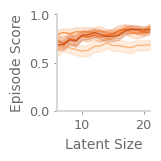

In [45]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 100, figsize=(1.5, 1.5),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=3,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    ylim=(0,1), ylabel='Episode Score', xlim=[6,21], figname='2c'
    )

In [ ]:
# Task B

zs = np.arange(2, 22)

recalculate = False
if recalculate:
    task_df = get_df('frozentransfer_new_gridworld8x8_shuffobs', zs, 'dm_large_q')
    with open('pickles/2c_frozentransfer.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/2c_frozentransfer.p', 'rb') as f:
        task_df = pickle.load(f)

np.unique(task_df['model'])

colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 100, figsize=(1.5, 1.5),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=3,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    ylim=(0,1), ylabel='Episode Score', xlim=[6,21], figname='2c'
    )